In [18]:
import torch
import scapy.all as scapy
import matplotlib.pyplot as plt

# consts
PCAP_PATH = "../datasets/weekday.pcap"
MAX_BITS_PORT = 16
MAX_BITS_SIZE = 11
PACKET_LENGTH = 264

In [19]:
# Read the pcap file
packets = scapy.rdpcap(PCAP_PATH)

In [20]:
def find_unique_layers(packets):
    """
    Find unique layers in the packet headers
    """
    unique_layers = []

    for packet in packets:
        if packet.haslayer(scapy.IP):
            # Extract the layers from the packet
            layers = packet.layers()

            # Add the layer names to the set of unique layers
            for layer in layers:
                unique_layers.append(layer.__name__)

    return unique_layers

# Find the unique layers in the packets
unique_layers = set(find_unique_layers(packets))

# Print the unique layers
print("Unique Layers in the IPv4 Packets:")
for layer in unique_layers:
    print(layer)

Unique Layers in the IPv4 Packets:
IP
UDP
Ether
DNS
Raw
ICMP
TCP
NTPHeader
Padding


Size of Image: torch.Size([264, 264])


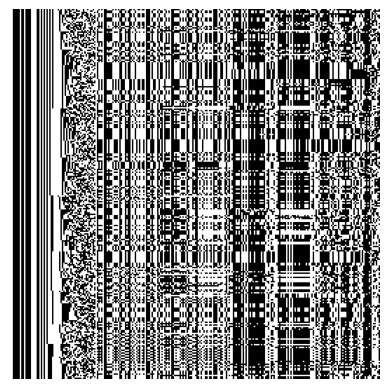

In [23]:
import struct

def extract_headers(pcap_file):
    """
    Extract headers from the packets and convert them to bits
    Headers includes:
    1. Timestamp of the packet
    2. Src and Dst MAC address
    3. If IP layer is present:
            Src and Dst IP address
    4. If TCP layer is present:
            Src and Dst port
    5. Size of the packet
    """
    packets = scapy.rdpcap(pcap_file)

    count = 0
    packets_tensor = []
    for packet in packets:

        try:
            #### Extract timestamp ####
            # Convert the integer part to binary
            integer_part = int(packet.time)
            binary_integer = bin(integer_part)[2:]

            # Convert the fractional part to binary
            fractional_part = packet.time - integer_part
            binary_fractional = bin(struct.unpack('!I', struct.pack('!f', fractional_part))[0])[2:]

            # Combine the integer and fractional binary parts
            timestamp_bits = binary_integer + binary_fractional

            #### Extract Src and Dst MAC Address ####
            # Ethernet header
            src_mac = packet[scapy.Ether].src.split(":")
            src_mac_bits = ''.join(format(int(digit, 16), '08b') for digit in src_mac)
            dst_mac = packet[scapy.Ether].dst.split(":")
            dst_mac_bits = ''.join(format(int(digit, 16), '08b') for digit in dst_mac)
            mac_bits = src_mac_bits + dst_mac_bits

            #### Extract Src and Dst IP Address ####
            # IP and TCP header
            if packet.haslayer(scapy.IP):
                src_ip = packet[scapy.IP].src.split(".")
                src_ip_bits = ''.join(format(int(octet), '08b') for octet in src_ip)
                dst_ip = packet[scapy.IP].dst.split(".")
                dst_ip_bits = ''.join(format(int(octet), '08b') for octet in dst_ip)
                ip_bits = src_ip_bits + dst_ip_bits

                #### Extract Src and Dst Port ####
                sport = None
                dport = None
                if packet.haslayer(scapy.TCP):
                    sport = packet[scapy.TCP].sport
                    dport = packet[scapy.TCP].dport
                elif packet.haslayer(scapy.UDP):
                    sport = packet[scapy.UDP].sport
                    dport = packet[scapy.UDP].dport
                else:
                    sport = 1055
                    dport = 1055
                
                sport_bits = format(sport, f'0{MAX_BITS_PORT}b')
                dport_bits = format(dport, f'0{MAX_BITS_PORT}b')
                port_bits = sport_bits + dport_bits
            
            #### Extract Packet Size ####
            packet_size = len(packet)
            packet_size_bits = format(packet_size, f'0{MAX_BITS_SIZE}b')

            #### Combine Each Bits ####
            packet_bits = timestamp_bits + mac_bits + ip_bits + port_bits + packet_size_bits
            packet_tensor = torch.tensor([int(bit) for bit in packet_bits])

            if count < PACKET_LENGTH:
                packets_tensor.append(packet_tensor)
                count = count + 1
            else:
                packet_image = torch.vstack(packets_tensor)
                print(f"Size of Image: {packet_image.shape}")
                plt.imshow(packet_image, cmap="gray")
                plt.axis("off")
                plt.show()
                packets_tensor = []
                count = 0
                break

        except:
            print(packet)

if __name__ == "__main__":
    extract_headers(PCAP_PATH)

In [15]:
import struct
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class GeneratedImagesDataset(Dataset):
    def __init__(self, pcap_file, transform=None):
        self.packets = scapy.rdpcap(pcap_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.packets)
    
    def __getitem__(self, index):
        packet = self.packets[index]

        try:
            #### Extract timestamp ####
            # Convert the integer part to binary
            integer_part = int(packet.time)
            binary_integer = bin(integer_part)[2:]

            # Convert the fractional part to binary
            fractional_part = packet.time - integer_part
            binary_fractional = bin(struct.unpack('!I', struct.pack('!f', fractional_part))[0])[2:]

            # Combine the integer and fractional binary parts
            timestamp_bits = binary_integer + binary_fractional

            #### Extract Src and Dst MAC Address ####
            # Ethernet header
            src_mac = packet[scapy.Ether].src.split(":")
            src_mac_bits = ''.join(format(int(digit, 16), '08b') for digit in src_mac)
            dst_mac = packet[scapy.Ether].dst.split(":")
            dst_mac_bits = ''.join(format(int(digit, 16), '08b') for digit in dst_mac)
            mac_bits = src_mac_bits + dst_mac_bits

            #### Extract Src and Dst IP Address ####
            # IP and TCP header
            if packet.haslayer(scapy.IP):
                src_ip = packet[scapy.IP].src.split(".")
                src_ip_bits = ''.join(format(int(octet), '08b') for octet in src_ip)
                dst_ip = packet[scapy.IP].dst.split(".")
                dst_ip_bits = ''.join(format(int(octet), '08b') for octet in dst_ip)
                ip_bits = src_ip_bits + dst_ip_bits

                #### Extract Src and Dst Port ####
                sport = None
                dport = None
                if packet.haslayer(scapy.TCP):
                    sport = packet[scapy.TCP].sport
                    dport = packet[scapy.TCP].dport
                elif packet.haslayer(scapy.UDP):
                    sport = packet[scapy.UDP].sport
                    dport = packet[scapy.UDP].dport
                else:
                    sport = 1055
                    dport = 1055
                
                sport_bits = format(sport, f'0{MAX_BITS_PORT}b')
                dport_bits = format(dport, f'0{MAX_BITS_PORT}b')
                port_bits = sport_bits + dport_bits
            
            #### Extract Packet Size ####
            packet_size = len(packet)
            packet_size_bits = format(packet_size, f'0{MAX_BITS_SIZE}b')

            #### Combine Each Bits ####
            packet_bits = timestamp_bits + mac_bits + ip_bits + port_bits + packet_size_bits
            packet_tensor = torch.tensor([int(bit) for bit in packet_bits])

            if count < PACKET_LENGTH:
                packets_tensor.append(packet_tensor)
                count = count + 1
            else:
                packet_image = torch.vstack(packets_tensor)
                print(f"Size of Image: {packet_image.shape}")
                plt.imshow(packet_image, cmap="gray")
                plt.axis("off")
                plt.show()
                packets_tensor = []
                count = 0
                break

        except:
            print(packet)

        if self.transform:
            packet_tensor = self.transform(packet_tensor)

        return packet_tensor

# Define transformations (if needed)
transform = transforms.Compose([
    # Add any desired transformations here
])

# Create the dataset
dataset = GeneratedImagesDataset(pcap_file=PCAP_PATH, transform=transform)

# Create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
for item in dataloader:
    print(item)


Ether / IP / TCP 192.168.0.111:57072 > 192.168.0.121:ezmeeting_2 A
Ether / IP / UDP 192.168.0.111:33310 > 192.168.0.121:10006 / Raw
Ether / IP / TCP 192.168.0.111:57072 > 192.168.0.121:ezmeeting_2 PA / Raw
Ether / IP / UDP 10.129.131.101:46485 > 239.255.255.250:ssdp / Raw
Ether / IP / UDP 216.58.199.78:https > 192.168.0.121:50079 / Raw
Ether / IP / TCP 47.241.108.13:15100 > 192.168.0.151:37924 A / Padding
Ether / IP / UDP 10.50.34.77:55144 > 239.255.255.250:ssdp / Raw
Ether / IP / UDP 192.168.0.121:10006 > 192.168.0.111:33310 / Raw
Ether / IP / UDP 192.168.0.111:33310 > 192.168.0.121:10006 / Raw
Ether / fe80::be0f:9aff:fe77:f174 > ff02::16 (0) / IPv6ExtHdrHopByHop / ICMPv6MLReport2


UnboundLocalError: local variable 'ip_bits' referenced before assignment

In [2]:
# Print packet details
for packet in packets:
    print(packet.summary())
    break

# Perform basic analysis and statistics
total_packets = len(packets)
total_layers = len(set([packet.name for packet in packets]))
total_src_ips = len(set([packet[IP].src for packet in packets if IP in packet]))
total_dst_ips = len(set([packet[IP].dst for packet in packets if IP in packet]))

# Print statistics
print("Total Packets:", total_packets)
print("Total Unique Layers:", total_layers)
print("Total Source IPs:", total_src_ips)
print("Total Destination IPs:", total_dst_ips)


Ether / IP / TCP 192.168.0.121:34512 > 142.250.66.195:https A
Total Packets: 20000
Total Unique Layers: 1
Total Source IPs: 502
Total Destination IPs: 246


Highest Number of Bits in a Packet: 11999


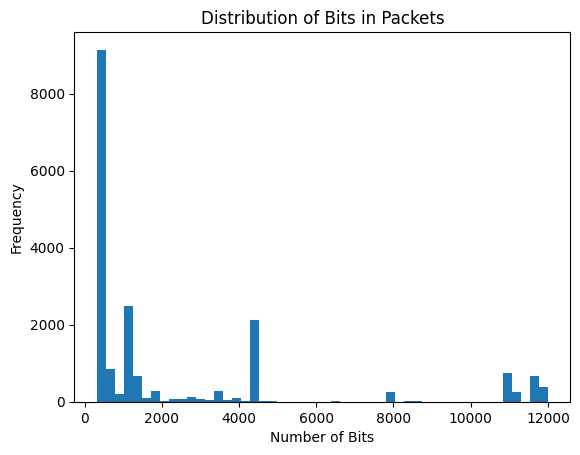

In [7]:
# Initialize the maximum number of bits
max_bits = 0

# Initialize a list to store the number of bits per packet
bits_per_packet = []

# Process each packet
for packet in packets:
    # print(packet.show())
    # break
    if "IP" in packet:
        # Extract the "IP" header
        ip_header = packet["IP"]

        # Convert the IP header to bits
        ip_header_bits = bin(int.from_bytes(bytes(ip_header), byteorder='big'))[2:]

        # Calculate the number of bits in the IP header
        num_bits = len(ip_header_bits)

        # Append the number of bits to the list
        bits_per_packet.append(num_bits)

    # Update the maximum number of bits if necessary
    if num_bits > max_bits:
        max_bits = num_bits

# Print the highest number of bits in a packet
print("Highest Number of Bits in a Packet:", max_bits)

# Plot the histogram
plt.hist(bits_per_packet, bins='auto')
plt.xlabel('Number of Bits')
plt.ylabel('Frequency')
plt.title('Distribution of Bits in Packets')
plt.show()

In [5]:
from scapy.all import rdpcap, wrpcap

# Path to the original pcap file
input_file = "../datasets/05-05-2021_weekday.pcap"

# Path to the output pcap file
output_file = "../datasets/weekday.pcap"

# Number of packets to extract
num_packets = 20000

# Read the original pcap file
packets = rdpcap(input_file)

# Take the first `num_packets` packets
filtered_packets = packets[:num_packets]

# Save the filtered packets to the output pcap file
wrpcap(output_file, filtered_packets)

In [6]:
import scapy.all as scapy

# Load the pcap file
pcap = scapy.rdpcap(PCAP_PATH)

initial_timestamp = 0
set_initial_timestamp = 0

# Iterate through the packets in the pcap file
for packet in pcap:

    # Get the timestamp of the packet
    timestamp = packet.time
    if not set_initial_timestamp:
        initial_timestamp = timestamp
        set_initial_timestamp = 1

    timestamp = timestamp - initial_timestamp
    if timestamp < 0.05:
        print(timestamp)
    else:
        print("Done!!!!")
        set_initial_timestamp = 0

    # Print the timestamp of the packet
    # print(timestamp)

0.000000
0.023026
0.023204
0.024978
0.037531
0.037665
Done!!!!
0.000000
0.004089
0.004885
0.022380
0.032779
Done!!!!
0.000000
0.007249
0.011938
0.017803
0.040320
Done!!!!
0.000000
0.000376
0.012963
Done!!!!
0.000000
0.030367
0.032125
0.032401
Done!!!!
0.000000
0.007321
0.028038
0.045216
Done!!!!
0.000000
0.010548
0.010640
0.011058
0.011946
0.028283
0.028308
Done!!!!
0.000000
0.000004
0.018509
0.018533
0.020339
0.020579
0.020940
0.021050
0.021070
Done!!!!
0.000000
0.000019
0.003368
0.022284
0.023692
0.032369
0.033058
0.048999
0.049257
0.049507
Done!!!!
0.000000
0.001433
0.001470
0.006113
0.007071
0.018204
0.023507
Done!!!!
0.000000
Done!!!!
0.000000
0.001311
0.043174
Done!!!!
0.000000
0.043591
0.043685
0.043710
0.045879
Done!!!!
0.000000
0.007034
0.007977
0.045057
0.045094
0.046646
0.046922
0.046941
0.047239
0.047338
0.047356
Done!!!!
0.000000
0.002520
0.003769
0.003820
0.003843
0.005471
0.005516
0.005538
0.005559
0.020990
0.026950
0.045289
Done!!!!
0.000000
0.002621
0.029628
0.029842
0